In [1]:
from number_of_districts import states as all_states
states = all_states.copy()
states.remove('HI')
print(states)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [2]:
from utils import read_graph_from_json, update_attributes, get_k_L_U
level = 'block'
district_types = ['SH', 'SS', 'CD']

****************************************
Starting AK SH
****************************************

Starting AK with k = 40 and deviation = 0.1
Thus, we have L = 17419 and U = 19251
Successfully processed plan with 24 whole counties.
Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-01
Adding non-dominated, minimal constraints:
['02195', '02275', '02198', '02130']
['02020']
['02110']
['02122']
['02170']
['02090']
Time to generate initial inequalities: 0.83 seconds.
****************************************
Starting AL SH
****************************************

Starting AL with k = 105 and deviation = 0.1
Thus, we have L = 45458 and U = 50242
Successfully processed plan with 36 whole counties.
Adding non-dominated, minimal constraints:
['01081']
['01043']
['01121']
['01077']
['01055']
['01125']
['01127']
['01101']
['01103']
['01097']
['01049']
['01003']
['01083']
['01115']
['01033']
['01073']
['01117']
['01113']
['01095']
['01089']
['01009']
['01071'

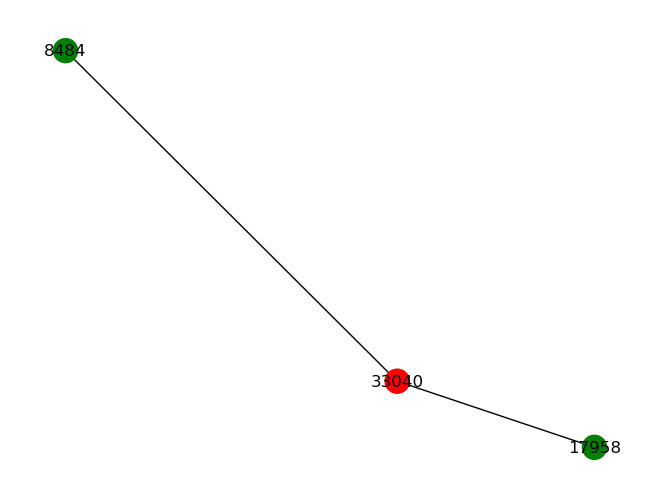

Seeking 8 districts for cluster #29/31 over n = 5168 vertices.
This cluster has counties {'05143'} of which set() are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 30733.88.
Used cached districts.
Seeking 1 districts for cluster #30/31 over n = 2332 vertices.
This cluster has counties {'05123', '05147'} of which {'05123', '05147'} are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 29359.0.
Seeking 2 districts for cluster #31/31 over n = 3683 vertices.
This cluster has counties {'05027', '05139'} of which {'05027'} are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 30927.5.
First, trying to draw districts at tract-level where n = 19.
Trying tract-level instance with n = 13.
Trying DAG model, with root geoids = ['05139951000', '05027']
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 ph

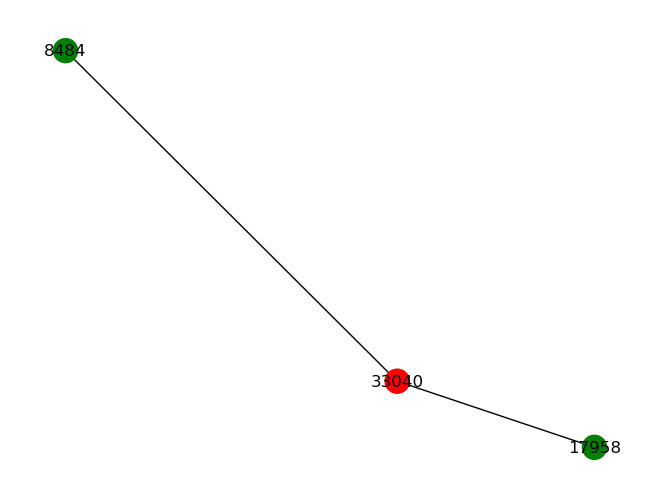

Seeking 9 districts for cluster #29/31 over n = 5993 vertices.
This cluster has counties {'05143', '05087'} of which {'05087'} are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 29154.67.
First, trying to draw districts at tract-level where n = 58.
Trying tract-level instance with n = 55.
Trying DAG model, with root geoids = ['05143010510', '05143011107', '05143011005', '05143010307', '05143010601', '05143010706', '05143010508', '05143010114', '05087']
Seeking 1 districts for cluster #30/31 over n = 2415 vertices.
This cluster has counties {'05095', '05123'} of which {'05095', '05123'} are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 29889.0.
Used cached districts.
Seeking 2 districts for cluster #31/31 over n = 3683 vertices.
This cluster has counties {'05027', '05139'} of which {'05027'} are whole.
Compare [L,U] = [28610, 31621] to p(cluster)/size = 30927.5.
Used cached districts.
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.

In [ ]:
from main import solve_max_whole
from utils import import_from_baf, export_to_baf

results = dict()
filepath = 'C:\\districting-data-2020-conn\\'
filepath2 = 'min-split-plans\\'

for district_type in district_types:
    for state in states:
        print(f"{'*'*40}\nStarting {state} {district_type}\n{'*'*40}\n")    
        filename = state + '_' + level + '.json'
        G = read_graph_from_json( filepath + filename )
        update_attributes(G, state)
        (k, L, U) = get_k_L_U(G, state, district_type)
        if k <= 1:
            print("Skipping because k <= 1.")
            continue
    
        # get warm start plan
        filename = 'min_county_splits_' + state + '_' + district_type + '_(by_Maral_Shahmizad_and_Austin_Buchanan_of_Oklahoma_State_University).baf'
        incumbent_plan = import_from_baf(G, filepath2, filename)
    
        # solve max whole
        results[state, district_type] = solve_max_whole(G, L, U, k, incumbent_plan, verbose=False)

        # export incumbent plan
        plan = results[state, district_type]['incumbent_plan']
        ga = { G.nodes[i]['GEOID20'] : j for j in range(len(plan)) for i in plan[j] }
        gap = results[state, district_type]['UB'] - results[state, district_type]['LB']
        if gap == 0:
            fn = "max_whole_counties_" + state + '_' + district_type + '_(by_Maral_Shahmizad_and_Austin_Buchanan_of_Oklahoma_State_University).baf'
        else:
            fn = "max_whole_counties_" + state + '_' + district_type + '_' + str(gap) + 'gap_(by_Maral_Shahmizad_and_Austin_Buchanan_of_Oklahoma_State_University).baf'
        export_to_baf(G, geoid_assignment=ga, outfilename=fn)
        
        # export partial plans?
        if gap > 0:
            counter = 0
            for plan in results[state, district_type]['incomplete_plans']:
                counter += 1
                ga = { G.nodes[i]['GEOID20'] : j for j in range(len(plan)) for i in plan[j] }
                fn = "incomplete_plan_" + state + "_" + district_type + "_" + str(counter) + ".baf"
                export_to_baf(G, geoid_assignment=ga, outfilename=fn)
    

In [ ]:
# number of whole districts in enacted plans for 118th congress, see enacted_whole.ipynb
enacted_whole = {('AK', 'CD'): 30, ('AL', 'CD'): 61, ('AR', 'CD'): 73, ('AZ', 'CD'): 8, ('CA', 'CD'): 31, ('CO', 'CD'): 53, ('CT', 'CD'): 3, ('DE', 'CD'): 3, ('FL', 'CD'): 50, ('GA', 'CD'): 144, ('HI', 'CD'): 4, ('IA', 'CD'): 99, ('ID', 'CD'): 43, ('IL', 'CD'): 70, ('IN', 'CD'): 84, ('KS', 'CD'): 101, ('KY', 'CD'): 114, ('LA', 'CD'): 49, ('MA', 'CD'): 5, ('MD', 'CD'): 18, ('ME', 'CD'): 15, ('MI', 'CD'): 68, ('MN', 'CD'): 78, ('MO', 'CD'): 106, ('MS', 'CD'): 78, ('MT', 'CD'): 55, ('NC', 'CD'): 87, ('ND', 'CD'): 53, ('NE', 'CD'): 91, ('NH', 'CD'): 5, ('NJ', 'CD'): 7, ('NM', 'CD'): 24, ('NV', 'CD'): 13, ('NY', 'CD'): 46, ('OH', 'CD'): 74, ('OK', 'CD'): 71, ('OR', 'CD'): 25, ('PA', 'CD'): 53, ('RI', 'CD'): 4, ('SC', 'CD'): 36, ('SD', 'CD'): 66, ('TN', 'CD'): 85, ('TX', 'CD'): 224, ('UT', 'CD'): 24, ('VA', 'CD'): 123, ('VT', 'CD'): 14, ('WA', 'CD'): 32, ('WI', 'CD'): 60, ('WV', 'CD'): 55, ('WY', 'CD'): 23, ('AK', 'SS'): 21, ('AL', 'SS'): 48, ('AR', 'SS'): 42, ('AZ', 'SS'): 3, ('CA', 'SS'): 37, ('CO', 'SS'): 49, ('CT', 'SS'): 0, ('DE', 'SS'): 0, ('FL', 'SS'): 51, ('GA', 'SS'): 130, ('HI', 'SS'): 2, ('IA', 'SS'): 74, ('ID', 'SS'): 36, ('IL', 'SS'): 52, ('IN', 'SS'): 65, ('KS', 'SS'): 92, ('KY', 'SS'): 115, ('LA', 'SS'): 24, ('MA', 'SS'): 3, ('MD', 'SS'): 9, ('ME', 'SS'): 4, ('MI', 'SS'): 52, ('MN', 'SS'): 48, ('MO', 'SS'): 107, ('MS', 'SS'): 39, ('MT', 'SS'): 33, ('NC', 'SS'): 85, ('ND', 'SS'): 33, ('NE', 'SS'): 82, ('NH', 'SS'): 0, ('NJ', 'SS'): 3, ('NM', 'SS'): 9, ('NV', 'SS'): 12, ('NY', 'SS'): 37, ('OH', 'SS'): 73, ('OK', 'SS'): 50, ('OR', 'SS'): 21, ('PA', 'SS'): 44, ('RI', 'SS'): 0, ('SC', 'SS'): 19, ('SD', 'SS'): 51, ('TN', 'SS'): 86, ('TX', 'SS'): 231, ('UT', 'SS'): 14, ('VA', 'SS'): 108, ('VT', 'SS'): 4, ('WA', 'SS'): 21, ('WI', 'SS'): 30, ('WV', 'SS'): 43, ('WY', 'SS'): 10, ('AK', 'SH'): 18, ('AL', 'SH'): 28, ('AR', 'SH'): 24, ('AZ', 'SH'): 3, ('CA', 'SH'): 31, ('CO', 'SH'): 46, ('CT', 'SH'): 0, ('DE', 'SH'): 0, ('FL', 'SH'): 36, ('GA', 'SH'): 90, ('HI', 'SH'): 1, ('IA', 'SH'): 56, ('ID', 'SH'): 36, ('IL', 'SH'): 40, ('IN', 'SH'): 32, ('KS', 'SH'): 67, ('KY', 'SH'): 97, ('LA', 'SH'): 23, ('MA', 'SH'): 2, ('MD', 'SH'): 5, ('ME', 'SH'): 0, ('MI', 'SH'): 35, ('MN', 'SH'): 34, ('MO', 'SH'): 62, ('MS', 'SH'): 14, ('MT', 'SH'): 27, ('NC', 'SH'): 64, ('ND', 'SH'): 32, ('NH', 'SH'): 0, ('NJ', 'SH'): 3, ('NM', 'SH'): 10, ('NV', 'SH'): 10, ('NY', 'SH'): 18, ('OH', 'SH'): 48, ('OK', 'SH'): 35, ('OR', 'SH'): 17, ('PA', 'SH'): 22, ('RI', 'SH'): 0, ('SC', 'SH'): 13, ('SD', 'SH'): 49, ('TN', 'SH'): 57, ('TX', 'SH'): 229, ('UT', 'SH'): 15, ('VA', 'SH'): 82, ('VT', 'SH'): 1, ('WA', 'SH'): 21, ('WI', 'SH'): 19, ('WV', 'SH'): 13, ('WY', 'SH'): 7}

In [ ]:
print("state & $|C|$ & enacted & max-whole & enacted & max-whole & enacted & max-whole \\\\")
for state in states:
    row = [ state, results[state, 'SS']['|C|'] ]
    for district_type in ['CD','SS','SH']:
        key = (state, district_type)
        if key not in results.keys():
            row.append("--")
            row.append("--")
            continue
        
        if key in enacted_whole.keys():
            row.append( enacted_whole[key] )
        else:
            row.append( None )
        
        if key in results.keys():
            lb = results[state, district_type]['LB']
            ub = results[state, district_type]['UB']
        else:
            lb = None
            ub = None
        if lb == ub:
            row.append( lb )
        else:
            row.append( [lb, ub] )

    for p in range(len(row)):
        if p < len(row)-1:
            print(row[p], end=' & ')
        else:
            print(row[p], end=' \\\\ ')
    print("")
